# Import Libraries

In [32]:
import pandas as pd, numpy as np #basic package
from scipy import stats
from sklearn import preprocessing
from copy import deepcopy
from collections import Counter

# Data Exploration

In [33]:
# Data Exploration
data = pd.read_csv('diabetic_data.csv', na_values = ["?","Unknown/Invalid",""])
print(data.shape)
#data.head()
#data.info()
print(data.iloc[:,0:11].describe(include = 'all'))
print(data.iloc[:,11:21].describe(include = 'all'))
print(data.iloc[:,21:31].describe(include = 'all')) # chlorpropamide，acetohexamide
print(data.iloc[:,31:41].describe(include = 'all')) # tolbutamide,miglitol, troglitazone, tolazamide, examide, citoglipton
print(data.iloc[:,41:51].describe(include = 'all')) # glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone
# metformin-pioglitazone
data.isnull().T.any().T.sum() # 100723 incomplete cases
data.isnull().sum() # Weight, payer_code, medical_specialty has about half missing values
#data.gender.value_counts() # Unknown/Invalid as a gender type

/Users/toothacher17/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(101766, 50)
        encounter_id   patient_nbr       race  gender      age    weight  \
count   1.017660e+05  1.017660e+05      99493  101763   101766      3197   
unique           NaN           NaN          5       2       10         9   
top              NaN           NaN  Caucasian  Female  [70-80)  [75-100)   
freq             NaN           NaN      76099   54708    26068      1336   
mean    1.652016e+08  5.433040e+07        NaN     NaN      NaN       NaN   
std     1.026403e+08  3.869636e+07        NaN     NaN      NaN       NaN   
min     1.252200e+04  1.350000e+02        NaN     NaN      NaN       NaN   
25%     8.496119e+07  2.341322e+07        NaN     NaN      NaN       NaN   
50%     1.523890e+08  4.550514e+07        NaN     NaN      NaN       NaN   
75%     2.302709e+08  8.754595e+07        NaN     NaN      NaN       NaN   
max     4.438672e+08  1.895026e+08        NaN     NaN      NaN       NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          3
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

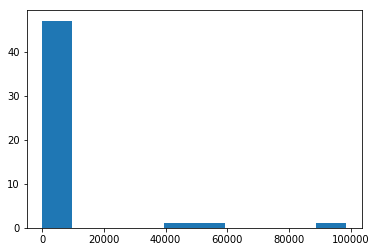

In [35]:
#data.info()
#import matplotlib.pyplot as plt
#plt.hist(data.isnull().sum())
#plt.show()

# Transformation of labels

In [36]:
#table of readmission status column
print(data.readmitted.value_counts())
readmitted_tran = data.readmitted.apply(lambda x: 1 if x == "<30" else 0)
print(readmitted_tran.value_counts())
print(readmitted_tran.value_counts()/101766)

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64
0    90409
1    11357
Name: readmitted, dtype: int64
0    0.888401
1    0.111599
Name: readmitted, dtype: float64


# Drop Variables 

In [37]:
df = data.copy()
df = df.drop(["encounter_id"], axis = 1) # unrelated variable
df = df.drop(["patient_nbr"],1) # unrelated variable
df = df.drop(["chlorpropamide",
           "acetohexamide",
           "tolbutamide",
           "miglitol", 
           "troglitazone", 
           "tolazamide", 
           "examide", 
           "citoglipton",
           "glipizide-metformin", 
           "glimepiride-pioglitazone",
           "metformin-rosiglitazone",
           "metformin-pioglitazone"],axis = 1)# duplicates > 101700
df = df.drop(["readmitted"],1)
df = df.drop(["weight"],1) # too many missing values
print(df.shape)
#print(df.info())

(101766, 34)


# Check Data Type

In [38]:
df.admission_type_id = df.admission_type_id.astype("category")
df.discharge_disposition_id = df.discharge_disposition_id.astype("category")
df.admission_source_id = df.admission_source_id.astype("category")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 34 columns):
race                        99493 non-null object
gender                      101763 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null category
discharge_disposition_id    101766 non-null category
admission_source_id         101766 non-null category
time_in_hospital            101766 non-null int64
payer_code                  61510 non-null object
medical_specialty           51817 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101745 non-null object
diag_2                      101408 non-null object
diag_3                    

# Missing Values Imputation

In [39]:
df['race'].replace(np.nan, 'Caucasian', inplace = True)
df["medical_specialty"].replace(np.nan, 'InternalMedicine', inplace = True)
df["payer_code"].replace(np.nan, 'MC', inplace = True)
df["diag_1"].replace(np.nan, '428', inplace = True)
df["diag_2"].replace(np.nan, '276', inplace = True)
df["diag_3"].replace(np.nan, '250', inplace = True)
df["gender"].replace(np.nan, 'Female', inplace = True)
df.isnull().sum()
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 34 columns):
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
admission_type_id           101766 non-null category
discharge_disposition_id    101766 non-null category
admission_source_id         101766 non-null category
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 non-null int64
diag_1                      101766 non-null object
diag_2                      101766 non-null object
diag_3                 

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
       'glyburide-metformin', 'change', 'diabetesMed'],
      dtype='object')

# Group diag_1, diag_2, diag_3

In [40]:
# function to regroup diag_1, diag_2, diag_3 codes

def group_diag(diags):
    groups = []
    other = []
    group = "null"
    for diag in diags:
        try:
            diag = pd.to_numeric(diag)
            if diag >= 390 and diag <= 459.789:
                diag = "Circulatory"
            elif diag >= 460 and diag <= 529.786:
                diag = "Respiratory"
            elif diag >= 520 and diag <= 579.787:
                diag = "Digestive"                    
            elif diag >= 250 and diag < 251:
                diag = "Diabetes"
            elif diag >= 800 and diag <=999:
                diag = "Injury"
            elif diag >= 710 and diag <=739:
                diag = "Musculoskeletal"
            elif diag >= 580 and diag <=629.788:
                diag = "Neoplasms"
            elif diag >= 780 and diag <= 799.9:
                diag = "Symptoms"
            elif diag >= 680 and diag <= 709.9:
                diag = "Skin"
            elif diag >= 276 and diag <= 279.9:
                diag = "Endoctrine"
            else:
                other.append(diag)
                diag = "other"
        except ValueError:
            other.append(diag)
            diag = "other"
        groups.append(diag)
    return([groups, other])

In [41]:
# import re
# data.diag_1[data.diag_1.apply(lambda x: True if re.match("[a-zA-Z].", str(x)) is not None else False)].value_counts()
# data.diag_2[data.diag_2.apply(lambda x: True if re.match("[a-zA-Z].", str(x)) is not None else False)].value_counts()
# data.diag_3[data.diag_3.apply(lambda x: True if re.match("[a-zA-Z].", str(x)) is not None else False)].value_counts()

g_diag_1 = group_diag(df.diag_1)
g_diag_2 = group_diag(df.diag_2)
g_diag_3 = group_diag(df.diag_3)

# Check whether there are big categories ignored in "other"
# Counter(g_diag_1[1])
# Counter(g_diag_2[1])
# Counter(g_diag_3[1])

### Normalize Numerical Variable

In [42]:
numeric_list = ["time_in_hospital","num_lab_procedures","num_procedures","num_medications",
               "number_outpatient","number_emergency","number_inpatient","number_diagnoses"]
df[numeric_list].apply(pd.to_numeric)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,1,41,0,1,0,0,0,1
1,3,59,0,18,0,0,0,9
2,2,11,5,13,2,0,1,6
3,2,44,1,16,0,0,0,7
4,1,51,0,8,0,0,0,5
5,3,31,6,16,0,0,0,9
6,4,70,1,21,0,0,0,7
7,5,73,0,12,0,0,0,8
8,13,68,2,28,0,0,0,8
9,12,33,3,18,0,0,0,8


In [44]:
normalizer = preprocessing.Normalizer().fit(df[numeric_list])
normalized = normalizer.transform(df[numeric_list])
df_normalized = pd.DataFrame(normalized, columns = ["time_in_hospital","num_lab_procedures","num_procedures","num_medications",
               "number_outpatient","number_emergency","number_inpatient","number_diagnoses"] )
#print(df_normalized)
df = pd.concat([df.drop(numeric_list,1),df_normalized],1)

# Tranfer categorical variables to dummy variables

In [45]:
df2 = df.copy()
df2['g_diag_1'] = g_diag_1[0]
df2['g_diag_2'] = g_diag_2[0]
df2['g_diag_3'] = g_diag_3[0]

print(df2.shape)
print(df.shape)

(101766, 37)
(101766, 34)


In [46]:
# for df with not-grouped diags
dummies = pd.get_dummies(df[['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                             'admission_source_id','payer_code', 'medical_specialty', 
                             'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                             'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                             'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                             'glyburide-metformin', 'change', 'diabetesMed']], 
                         prefix= ['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                                  'admission_source_id','payer_code', 'medical_specialty',
                                  'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                                  'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                                  'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                                  'glyburide-metformin', 'change', 'diabetesMed'])


# for df2 with grouped diags
dummies2 = pd.get_dummies(df2[['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                   'admission_source_id','payer_code', 'medical_specialty', 
                   'g_diag_1', 'g_diag_2', 'g_diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                   'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                   'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                   'glyburide-metformin', 'change', 'diabetesMed']], 
               prefix= ['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                   'admission_source_id','payer_code', 'medical_specialty', 
                   'g_diag_1', 'g_diag_2', 'g_diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                   'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                   'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                   'glyburide-metformin', 'change', 'diabetesMed'])



In [47]:
df = pd.concat([df, dummies],1).drop(['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                   'admission_source_id','payer_code', 'medical_specialty', 
                   'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                   'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                   'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                   'glyburide-metformin', 'change', 'diabetesMed'],1)

df2 = pd.concat([df2, dummies2],1).drop(['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id',
                   'admission_source_id','payer_code', 'medical_specialty', 
                   'diag_1', 'diag_2', 'diag_3','g_diag_1', 'g_diag_2', 'g_diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
                   'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
                   'pioglitazone', 'rosiglitazone', 'acarbose', 'insulin',
                   'glyburide-metformin', 'change', 'diabetesMed'],1)

In [48]:
df['readmitted'] = readmitted_tran
df2['readmitted'] = readmitted_tran
print(df2.shape)
print(df.shape)

(101766, 255)
(101766, 2475)


In [30]:
#print(df.head())
#print(df2.head())

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0          0.024369            0.999109        0.000000         0.024369   
1          0.048069            0.945362        0.000000         0.288416   
2          0.105409            0.579751        0.263523         0.685160   
3          0.042201            0.928427        0.021101         0.337610   
4          0.019277            0.983135        0.000000         0.154217   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0           0.000000               0.0          0.000000          0.024369   
1           0.000000               0.0          0.000000          0.144208   
2           0.105409               0.0          0.052705          0.316228   
3           0.000000               0.0          0.000000          0.147704   
4           0.000000               0.0          0.000000          0.096386   

   race_AfricanAmerican  race_Asian     ...      insulin_Up  \
0          

In [49]:
#df.to_csv("pp_5_2_ungrouped.csv")
#df2.to_csv("pp_5_1_grouped2.csv")